In [1]:
import torch

In [2]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.eps = 1e-5

    def forward(self, x:torch.Tensor):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * x_norm + self.shift
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_o = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x:torch.Tensor):
        batch, seq_len, dim = x.shape
        queries = self.W_q(x).view(batch, seq_len, self.num_heads, self.head_dim)
        keys = self.W_k(x).view(batch, seq_len, self.num_heads, self.head_dim)
        values = self.W_v(x).view(batch, seq_len, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2)  # (B, num_heads, L, head_dim)
        keys = keys.transpose(1, 2)        # (B, num_heads, L, head_dim)
        values = values.transpose(1, 2)    # (B, num_heads, L, head_dim)

        attn_scores = queries @ keys.transpose(-2, -1) / keys.shape[-1] ** 0.5 # （B, num_heads, L, L）
        attn_scores.masked_fill_(self.mask[:seq_len, :seq_len], -torch.inf)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values  # (B, num_heads, L, head_dim)
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch, seq_len, dim)  # (B, L, D)
        return self.W_o(context_vec)
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

class FeedForward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.fc1 = nn.Linear(emb_dim, 4 * emb_dim)
        self.fc2 = nn.Linear(4 * emb_dim, emb_dim)
        # self.act = nn.GELU()
        self.act = GELU()

    def forward(self, x:torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x
    
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.attn = MultiHeadAttention(cfg['emb_dim'], cfg['emb_dim'], cfg['context_length'], cfg['n_heads'], cfg['drop_rate'], cfg['qkv_bias'])
        self.ffn = FeedForward(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x:torch.Tensor):
        # 多头
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + shortcut
        # 前馈层
        shortcut = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        return x + shortcut

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emp = nn.Dropout(cfg['drop_rate'])
        self.blks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'])

    def forward(self, in_idx:torch.Tensor):
        batch, seq_len = in_idx.shape
        token_embeded = self.token_emb(in_idx) # (B,L,D)
        pos_embeded = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) # (L,D)
        x = token_embeded + pos_embeded  # (B,L,D)
        x = self.drop_emp(x) # (B,L,D)
        x = self.blks(x) # (B,L,D)
        x = self.final_norm(x) # (B,L,D)
        logits = self.out_head(x) # (B,L,V)
        return logits

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emp): Dropout(p=0.1, inplace=False)
  (blks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (W_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_fe

In [4]:
file_path = 'the-verdict.txt'
with  open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [5]:
import torch
import tiktoken
from torch.utils.data import Dataset,DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)
        for idx in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[idx:idx+max_length]
            target_chunk = token_ids[idx+1:idx+1+max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]
    
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding('gpt2')
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    return DataLoader(dataset, batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

In [6]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [11]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01
warmup_steps = 20

total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print(warmup_steps)

27


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        # 设置学习率
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        track_lrs.append(optimizer.param_groups[0]['lr'])

        ## TODO: 前面是设置优化器的学习率，这里才是模型反向传播backward的代码以及权重更新

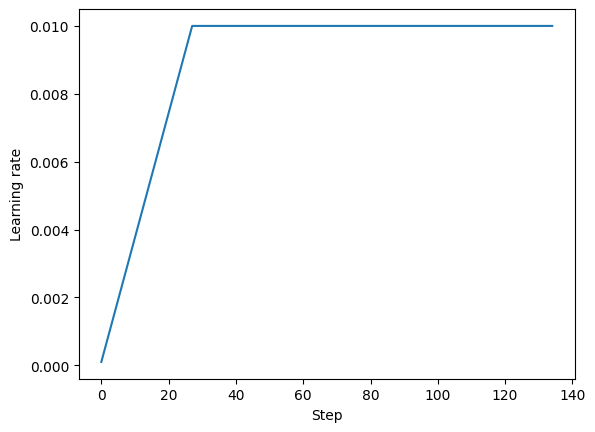

In [13]:
import matplotlib.pyplot as plt
plt.ylabel('Learning rate')
plt.xlabel('Step')
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.show()

In [18]:
len(optimizer.param_groups),optimizer.param_groups[0].keys()

(1,
 dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'foreach', 'maximize', 'capturable', 'differentiable', 'fused']))

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
optimizer.param_groups[0]['lr']

0.001

In [20]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []
lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        if global_step < warmup_steps:
            # 线性预热
            lr = initial_lr + global_step * lr_increment
        else:
            # 余弦衰减
            progress = ((global_step - warmup_steps) / (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (1+math.cos(math.pi * progress))

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        track_lrs.append(optimizer.param_groups[0]['lr'])

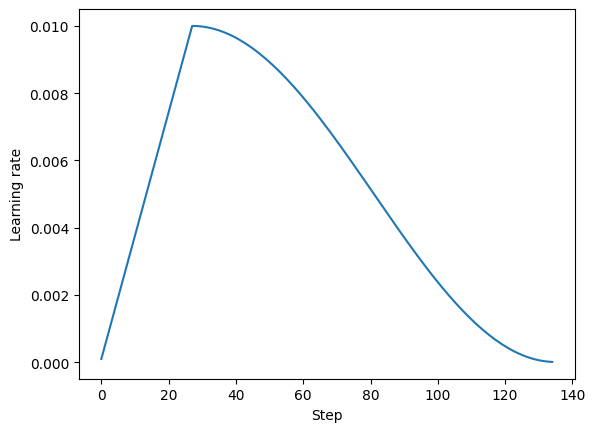

In [21]:
import matplotlib.pyplot as plt
plt.ylabel('Learning rate')
plt.xlabel('Step')
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.show()

In [22]:
def calc_loss_batch(input_batch:torch.Tensor, target_batch:torch.Tensor, model:nn.Module, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.permute(0,2,1), target_batch)
    return loss

In [23]:
# 梯度裁剪
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

In [25]:
def find_higest_gradient(model:nn.Module):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

print(find_higest_gradient(model))

tensor(0.0624, device='cuda:0')


In [27]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_higest_gradient(model))

tensor(0.0268, device='cuda:0')


In [28]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches: # 这个是为了兼容指定的num_batches小于data_loader的总batch数的情况
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


In [29]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # 取从当前序列的最后context_size个token作为条件输入
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # 取最后一个时间步的logits
        # probas = torch.softmax(logits, dim=-1)
        # idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # logits和probas的大小关系是对应的，所以可以直接对logits应用argmax得到词元id
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [31]:
device

device(type='cuda')

In [32]:
import tiktoken
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 添加batch维度
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(model=model, idx=text_to_token_ids(start_context, tokenizer).to(device), max_new_tokens=10, context_size=GPT_CONFIG_124M['context_length'])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingusually maintenance cones majority radiant instructional Gael Palestinian314


In [34]:
def evaluate_model(model:nn.Module, train_loader:DataLoader, val_loader:DataLoader, device:torch.device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model:nn.Module, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, encoded, max_new_tokens=50, context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n',''))
    model.train()

In [ ]:
def train_model(model:nn.Module, train_loader:DataLoader, val_loader:DataLoader, optimizer:torch.optim.Optimizer, device:torch.device, n_epochs, eval_freq, eval_iter, start_context, tokenizer, warmup_steps, initial_lr=3e-5, min_lr=1e-6):
    train_losses, val_losses, track_tokens_seen, track_lrs = [],[],[],[]
    tokens_seen, global_step = 0, -1

    peak_lr = optimizer.param_groups[0]['lr'] # 取用户在优化器中设定的lr作为目标峰值lr
    total_training_steps = len(train_loader) * n_epochs
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment # 线性预热
            else:
                # 余弦衰减
                progress = ((global_step - warmup_steps) / (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1+math.cos(math.pi * progress))
            
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            track_lrs.append(lr)
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            tokens_seen += input_batch.numel()

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d})：Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")  
        
        # 每轮之后打印一个文本样本
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen, track_lrs


In [36]:
import tiktoken

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
peak_lr = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)
tokenizer = tiktoken.get_encoding('gpt2')

n_epochs = 15
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print(warmup_steps)
train_losses, val_losses, token_seen, lrs = train_model(model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs, eval_freq=5, eval_iter=1, start_context='Every effort moves you', tokenizer=tokenizer, warmup_steps=warmup_steps, initial_lr=1e-5, min_lr=1e-5)


27
Ep 1 (Step 000000)：Train loss 10.946, Val loss 10.945
Ep 1 (Step 000005)：Train loss 9.459, Val loss 9.817
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010)：Train loss 8.521, Val loss 8.902
Ep 2 (Step 000015)：Train loss 7.488, Val loss 7.902
Every effort moves you, the, the, the, the,,,, the, the,,,, the,,,,,,,,, the,, the,,,, the,,, the,,,,,,,,
Ep 3 (Step 000020)：Train loss 6.498, Val loss 6.996
Ep 3 (Step 000025)：Train loss 6.032, Val loss 6.591
Every effort moves you, the, the, the, the, the, the, the, I,, the,, I, I, the, I, the, the, the, the, the, I, the, the, the, I, I
Ep 4 (Step 000030)：Train loss 5.312, Val loss 6.467
Ep 4 (Step 000035)：Train loss 5.015, Val loss 6.381
Every effort moves you."I a a, and I had the picture."I, and I had been."I, and I had been the his he had the his the honour, and, and in the, and, and
Ep 5 (Step 000040)：Train loss 4.072, Val loss 6.259
Every effort moves you know the, and in the, in the, in a little 